In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym[box2d]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (857 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of 

In [4]:
# !python cartpole_dqn.py

In [5]:
import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
Display().start()

In [6]:
# 하이퍼 파라미터
EPISODES = 50    # 애피소드 반복횟수 (=총 플레이할 게임 수)
EPS_START = 0.9  # 학습 시작시 에이전트가 무작위로 행동할 확률 (나머지는 학습된 방향으로 행동)
EPS_END = 0.05   # 학습 막바지에 에이전트가 무작위로 행동할 확률 (초반에는 경험을 많이 쌓게 하고, 점차 학습하면서 똑똑해지니까 학습한대로 진행하게 함)
EPS_DECAY = 200  # 학습 진행시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8      # 할인계수 (=에이전트가 현재 보상을 미래 보상보다 얼마나 더 가치있게 여기는지에 대한 값)
LR = 0.001       # 학습률
BATCH_SIZE = 64  # 배치 크기

In [7]:
# DQN model 설계
class DQNAgent:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(4, 256),  # input (4) : 카트위치, 카트속도, 막대기각도, 막대기속도
            nn.ReLU(),
            nn.Linear(256, 2)   # output (2) : 왼쪽으로 갈 때의 가치, 오른쪽으로 갈 때의 가치
        )
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0
        self.memory = deque(maxlen=10000)

    # 이전에 경험한 것을 모두 배열에 담아 지속적으로 재학습하며 신경망이 잊어버리지 않도록 함
    # 기억해둔 경험들은 학습과정에서 무작위로 뽑아 경험간의 상관관계를 줄임
    # 경험함수(memorize)는 상태(state), 행동(action), 보상(reward)을 담고 있음. 즉, 에피소드를 저장
    def memorize(self, state, action, reward, next_state):
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])))
    
    # 행동 선택 함수
    def act(self, state):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1

        # 무작위 숫자와 Epsilon을 비교
        # 초반에는 Epsilon을 높게 잡아 최대한 경험을 많이 하도록 하고
        # 점차 Epsilon을 낮춰가며 신경망이 옳다고 생각하는 방향으로 선택
        if random.random() > eps_threshold:
            # random값 > Epsilon값 => 학습된 신경망이 옳다고 생각하는 방향으로!
            return self.model(state).data.max(1)[1].view(1, 1)
        else:
            # random값 < Epsilon값 => 무작위로 행동
            return torch.LongTensor([[random.randrange(2)]])
    
    # 메모리에 쌓아둔 경험들을 재학습(replay)하며, 학습하는 함수
    def learn(self):

        # 메모리에 저장된 에피소드가 batch크기보다 작으면 학습을 하지 않음
        if len(self.memory) < BATCH_SIZE:
            return

        # 경험이 충분히 쌓인 후부터 학습 진행
        batch = random.sample(self.memory, BATCH_SIZE)        # 메모리에서 random하게 batch size만큼 가져와서 학습
        states, actions, rewards, next_states = zip(*batch)   # 기존의 batch를 요소별 리스트로 분리해줄 수 있게 함

        # list to tensor
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        current_q = self.model(states).gather(1, actions)         # model의 입력으로 states 제공. 현 상태에서 했던 행동의 가치(Q값)를 current_q로 모음
        max_next_q = self.model(next_states).detach().max(1)[0]   # 에이전트가 보는 행동의 미래 가치(max_next_q)
        expected_q = rewards + (GAMMA * max_next_q)               # rewards(보상) + 미래가치
        
        # 행동은 expected_q를 따라가게끔, MSE_loss로 오차계산
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()

        # 역전파, 신경망 학습
        loss.backward()
        self.optimizer.step()

In [8]:
env = gym.make('CartPole-v0')   # env : 게임환경 (원하는 게임을 make 함수에 넣어줌)
agent = DQNAgent()
score_history = []              # 점수 저장용

In [9]:
# 모델 학습
for e in range(1, EPISODES+1):
    state = env.reset()                       # 매 시작마다 환경 초기화
    steps = 0
    while True:                               # 게임이 끝날 때까지 무한루프
        env.render()
        state = torch.FloatTensor([state])    # 현 상태를 Tensor화

        # 에이전트의 action 함수의 입력으로 state 제공
        # Epsilon Greedy에 따라 행동 선택
        action = agent.act(state)

        # action : item 함수로 에이전트가 수행한 행동의 번호 추출
        next_state, reward, done, _ = env.step(action.item())

        # 게임이 끝났을 경우 마이너스 보상주기
        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1

        if done:
            print("Episode : {0}\tScore: {1}".format(e, steps))
            score_history.append(steps)
            break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  import sys


Episode : 1	Score: 35
Episode : 2	Score: 27
Episode : 3	Score: 26
Episode : 4	Score: 12
Episode : 5	Score: 14
Episode : 6	Score: 10
Episode : 7	Score: 13
Episode : 8	Score: 15
Episode : 9	Score: 14
Episode : 10	Score: 13
Episode : 11	Score: 10
Episode : 12	Score: 9
Episode : 13	Score: 24
Episode : 14	Score: 11
Episode : 15	Score: 12
Episode : 16	Score: 10
Episode : 17	Score: 11
Episode : 18	Score: 8
Episode : 19	Score: 11
Episode : 20	Score: 10
Episode : 21	Score: 9
Episode : 22	Score: 8
Episode : 23	Score: 17
Episode : 24	Score: 11
Episode : 25	Score: 55
Episode : 26	Score: 15
Episode : 27	Score: 18
Episode : 28	Score: 22
Episode : 29	Score: 16
Episode : 30	Score: 20
Episode : 31	Score: 19
Episode : 32	Score: 28
Episode : 33	Score: 44
Episode : 34	Score: 60
Episode : 35	Score: 68
Episode : 36	Score: 86
Episode : 37	Score: 110
Episode : 38	Score: 120
Episode : 39	Score: 114
Episode : 40	Score: 157
Episode : 41	Score: 83
Episode : 42	Score: 174
Episode : 43	Score: 107
Episode : 44	Score

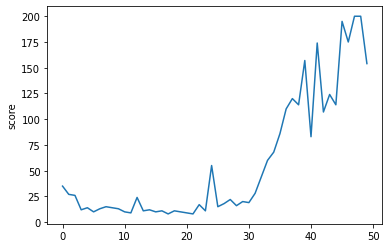

In [10]:
# 점수 시각화
plt.plot(score_history)
plt.ylabel('score')
plt.show()